**Table of contents**<a id='toc0_'></a>    
- [Test No data frame single likelihood](#toc1_)    
- [Test No data frame multiple likelihood](#toc2_)    
- [Indices](#toc3_)    
- [Model comparaison](#toc4_)    
- [Multiple indices](#toc5_)    
- [ Categorical interactions](#toc6_)    
- [ Continuous interactions](#toc7_)    
- [Binomial model](#toc8_)    
- [Binomial with index](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Test No data frame single likelihood](#toc0_)

In [ ]:
from  main import *
formula = dict(main = 'y~Normal(m,s)',
            likelihood = 'm ~  alpha + beta',
            prior1 = 's~Exponential(1)',
            prior2 = 'alpha ~ Normal(0,1)',
            prior3 = 'beta ~ Normal(0,1)')  
self = model(formula= formula, float = 16) 
self.sample()

# <a id='toc2_'></a>[Test No data frame multiple likelihood](#toc0_)

In [ ]:
from  main import *
## Model m4.3
d = pd.read_csv('./data/Howell1.csv', sep=';')
d = d[d.age > 18]
#self.df["weight.per.g"].pipe(lambda x: (x - x.mean()) / x.std())
d.weight = d.weight - d.weight.mean()
d.age = d.age - d.age.mean()
formula = dict(main1 = 'height ~ Normal(mu,sigma)',
            likelihood = 'mu ~ alpha + beta * weight',
            prior1 = 'sigma ~ Uniform(0,50)',
            prior2 = 'alpha ~ Normal(178,20)',
            prior3 = 'beta ~ Normal(0,1)')    

self = model(formula, df = d, float = 32)
print('tensor DICT:')
print(self.tensor_dict)
print('tensor likelihoods:')
print(self.main_text)
self.fit(observed_data = dict(height =d.height.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
self.summary()

# expected 
#           Mean    StdDev  5.5%    94.5%   a   b   sigma
#   a       154.60  0.27    154.17  155.03  1   0   0
#   b       0.91    0.04    0.84    0.97    0   1   0
#   sigma   5.07    0.19    4.77    5.38    0   0   1

# <a id='toc3_'></a>[Indices](#toc0_)

In [ ]:
## Model m5.9 
from  main import *
self = model()
self.import_csv('./data/milk.csv', sep = ';')
self.df["K"] = self.df["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())
self.index(cols = "clade")

formula = dict(main = 'K ~ Normal(mu,sigma)',
            likelihood = 'mu ~ alpha[index_clade]',
            prior1 = 'alpha~ Normal(0,0.5)',
            prior2 = 'sigma ~ Exponential(1)') 

self.formula(f = formula)
self.build_model()
self.fit(observed_data = dict(K =self.df.K.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
self.summary()

# Expected:
#                mean	sd	    hdi_5.5%	hdi_94.5%
# ape_alpha	    -0.48	0.27	-0.93	    -0.08
# nwm_alpha	    0.37	0.22	0.03	    0.73
# owm_alpha	    0.65	0.30	0.26	    1.18
# strep_alpha	-0.55	0.29	-1.07	    -0.19
# sigma	        0.83	0.13	0.67	    1.06

# <a id='toc4_'></a>[Model comparaison](#toc0_)

In [ ]:
from  main import*
# m8.1
m = model()
d = pd.read_csv('./data/rugged.csv', sep = ';')
# make log version of outcome
d['log_gdp'] = np.log(d.rgdppc_2000)
# extract countries with GDP data

# rescale variables
d['log_gdp_std'] = d["log_gdp"].pipe(lambda x: (x / x.mean()) )
d['rugged_std'] = d["rugged"].pipe(lambda x: (x / x.max()) )
d['rugged_std'] - 0.215
d = d.loc[:,['rugged_std','log_gdp_std', 'cont_africa','log_gdp']]
d = d.dropna()
formula = dict(
    main = 'log_gdp_std ~ Normal( mu , sigma ) ',
    likelihood = 'mu ~ a + b* rugged_std ',
    prior1 = 'a ~ Normal( 1 , 0.1  )' ,
    prior2 = 'b ~ Normal( 0 , 0.3 )' ,
    prior3 = 'sigma ~ Exponential( 1 )'
)

m8_1 = model(formula, d)

m8_1.fit(observed_data = dict(log_gdp_std =d.log_gdp_std.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m8_1.summary()

#Expected:
#       mean    sd      5.5%    94.5%
#a      1.00    0.01    0.98    1.0
#b      0.00    0.05    -0.09   0.09
#sigma  0.14    0.01    0.12    0.15


In [ ]:

d = pd.read_csv('./data/rugged.csv', sep = ';')
d["log_gdp"] = d["rgdppc_2000"].pipe(np.log)

# extract countries with GDP data
dd = d[d["rgdppc_2000"].notnull()].copy()

# rescale variables
dd["log_gdp_std"] = dd.log_gdp / dd.log_gdp.mean()
dd["rugged_std"] = dd.rugged / dd.rugged.max()

dd["cid"] = np.where(dd.cont_africa.values == 1, 0, 1)
dd["cid"]

formula = dict(
    main = 'log_gdp_std ~ Normal( mu , sigma ) ',
    likelihood = 'mu ~ a[cid] + b*rugged_std',
    prior1 = 'a ~ Normal( 1 , 0.1  )' ,
    prior2 = 'b ~ Normal( 0 , 0.3 )' ,
    prior3 = 'sigma ~ Exponential( 1 )'
)

m8_2= model(formula, dd)
m8_2.fit(observed_data = dict(log_gdp_std =dd.log_gdp_std.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m8_2.summary()

#Expected:
#       mean    sd      5.5%    94.5%
#a[1]   0.88    0.02    0.85    0.91
#a[2]   1.05    0.01    1.03    1.07
#b      -0.05   0.05    -0.12   0.03
#sigma  0.11    0.01    0.10    0.1



In [ ]:
m8_2.diag_compare({'m8.1': m8_1.trace, 'm8.2': m8_2.trace})
#       rank	elpd_loo	p_loo	    elpd_diff	weight	se	    dse	    warning	    scale
#m8.2	0	    128.021790	3.008224	0.000000	1.0	    0.0	    0.0	    True	    log
#m8.1	1	    95.414886	2.317650	32.606903	0.0	    0.0	    0.0	    True	    log

# <a id='toc5_'></a>[Multiple indices](#toc0_)

In [ ]:
# m8.3
from main import*
d = pd.read_csv('./data/rugged.csv', sep = ';')
d["log_gdp"] = d["rgdppc_2000"].pipe(np.log)

# extract countries with GDP data
dd = d[d["rgdppc_2000"].notnull()].copy()

# rescale variables
dd["log_gdp_std"] = dd.log_gdp / dd.log_gdp.mean()
dd["rugged_std"] = dd.rugged / dd.rugged.max()

dd["cid"] = np.where(dd.cont_africa.values == 1, 0, 1)
dd["cid"]


formula = dict(
    main = 'log_gdp_std ~ Normal( mu , sigma ) ',
    likelihood = 'mu ~ a[cid] + b[cid]*rugged_std',
    prior1 = 'a ~ Normal( 1 , 0.1  )' ,
    prior2 = 'b ~ Normal( 0 , 0.3 )' ,
    prior3 = 'sigma ~ Exponential( 1 )'
)

m8_3= model(formula, dd)
m8_3.fit(observed_data = dict(log_gdp_std =dd.log_gdp_std.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m8_3.summary()

# Expected:
#       mean    sd      5.5%    94.5%
#a[1]   0.89    0.02    0.86    0.91
#a[2]   1.05    0.01    1.03    1.07
#b[1]   0.13    0.07    0.01    0.25
#b[2]   -0.14   0.05    -0.23    -0.06
#sigma  0.11    0.01    0.10    0.12

# <a id='toc6_'></a>[ Categorical interactions](#toc0_)

In [ ]:
d = pd.read_csv('./data/tulips.csv', sep = ';')
d["blooms_std"] = d.blooms / d.blooms.max()
d["water_cent"] = d.water - d.water.mean()
d["shade_cent"] = d.shade - d.shade.mean()

formula = dict(
            main = 'blooms_std ~ Normal( mu , sigma ) ',
            likelihood ='mu ~ a + bw*water_cent + bs*shade_cent' ,
            prior1 = 'a ~ Normal( 0.5 , 0.25 ) ',
            prior2 = 'bw ~ Normal( 0 , 0.25 ) ',
            prior3 = 'bs ~ Normal( 0 , 0.25 ) ',
            prior4 = 'sigma ~ Exponential( 1 )',
            )
m8_4 = model(formula, d)
m8_4.fit(observed_data = dict(blooms_std =d.blooms_std.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m8_4.summary()
#Expected:
#       mean   sd       5.5%    94.5%
#a      0.36    0.03     0.31    0.41
#bw     0.21    0.04     0.15    0.26
#bs    -0.11    0.04    -0.17   -0.05
#sigma  0.16    0.02     0.12    0.19

# <a id='toc7_'></a>[ Continuous interactions](#toc0_)

In [ ]:
## Model m8.3
d = pd.read_csv('./data/tulips.csv', sep = ';')
d["blooms_std"] = d.blooms / d.blooms.max()
d["water_cent"] = d.water - d.water.mean()
d["shade_cent"] = d.shade - d.shade.mean()

formula = dict(
            main = 'blooms_std ~ Normal( mu , sigma ) ',
            likelihood ='mu ~ a + bw*water_cent + bs*shade_cent + bws*water_cent*shade_cent' ,
            prior1 = 'a ~ Normal( 0.5 , 0.25 ) ',
            prior2 = 'bw ~ Normal( 0 , 0.25 ) ',
            prior3 = 'bs ~ Normal( 0 , 0.25 ) ',
            prior4 = 'bws ~ Normal( 0 , 0.25 ) ',
            prior5 = 'sigma ~ Exponential( 1 )',
            )
m8_5 = model(formula, d)
m8_5.fit(observed_data = dict(blooms_std =d.blooms_std.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m8_5.summary()

# Expected
#       mean   sd  5.5% 94.5%
#a      0.36 0.02  0.32  0.40
#bw     0.21 0.03  0.16  0.25
#bs    -0.11 0.03 -0.16 -0.07
#bws   -0.14 0.04 -0.20 -0.09
#sigma  0.12 0.02  0.10  0.15

# <a id='toc8_'></a>[Binomial model](#toc0_)

In [ ]:
from main import*
d = pd.read_csv('./data/chimpanzees.csv', sep = ';')
d["treatment"] = 1 + d.prosoc_left + 2 * d.condition
d["side"] = d.prosoc_left  # right 0, left 1
d["cond"] = d.condition  # no partner 0, partner 1

d_aggregated = (
    d.groupby(["treatment", "actor", "side", "cond"])["pulled_left"].sum().reset_index()
)
d_aggregated.rename(columns={"pulled_left": "left_pulls"}, inplace=True)
d_aggregated["actor_id"] = d_aggregated["actor"].values - 1

formula = dict(
    main = 'pulled_left ~ Binomial( 1 , logits = p )' ,
    likelihood = 'p ~ a' ,
    prior1 = 'a ~ Normal( 0 , 10 )'
)

m11_1 = model(formula, d)
m11_1.fit(observed_data = dict(pulled_left =d.pulled_left.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m11_1.summary()


# expected
#  mean   sd 5.5% 94.5%
#a 0.32 0.09 0.18  0.46

# <a id='toc9_'></a>[Binomial with index](#toc0_)

In [1]:
from main import*
d = pd.read_csv('./data/chimpanzees.csv', sep = ';')
d.actor = d.actor - 1
d["treatment"] = d.prosoc_left + 2 * d.condition
d[["actor", "prosoc_left", "condition", "treatment"]]


formula = dict(
    main = 'pulled_left ~ Binomial(1 , p )' ,
    likelihood = 'p ~ a[actor] + b[treatment]' ,
    prior1 = 'a ~ Normal(0,1.5)',
    prior2 = 'b ~ Normal(0,0.5)'
)
m11_4 = model(formula, d, float = 32)
m11_4.fit(observed_data = dict(pulled_left =d.pulled_left.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m11_4.summary()
# Expected
#          mean    sd   5.5%    94.5%   n_eff Rhat
#a[1]   -0.45    0.32   -0.95    0.04   690 1
#a[2]   3.86     0.73   2.78     5.09   1417 1
#a[3]   -0.75    0.33   -1.28    -0.23   765 1
#a[4]   -0.74    0.33   -1.26    -0.21   887 1
#a[5]   -0.44    0.32   -0.94    0.10   743 1
#a[6]   0.48     0.32   -0.02    1.00   894 1
#a[7]   1.95     0.40   1.32    2.63    882 1
#b[1]   -0.04    0.28   -0.51    0.40   669 1
#b[2]   0.48     0.28   0.04    0.92    675 1
#b[3]   -0.38    0.28   -0.83    0.06    768 1
#b[4]   0.37     0.27   -0.07    0.79   666 1


2024-02-06 15:02:56.072068: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-06 15:02:56.091609: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 15:02:56.091628: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 15:02:56.092147: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 15:02:56.095734: I tensorflow/core/platform/cpu_feature_guar

,mean,sd,hdi_5.5%,hdi_94.5%
b[0],-0.03,0.28,-0.50,0.41
b[1],0.49,0.28,0.04,0.94
b[2],-0.37,0.28,-0.84,0.06
b[3],0.39,0.28,-0.03,0.87
a[0],-0.46,0.33,-0.96,0.09
a[1],3.88,0.75,2.75,5.09
a[2],-0.76,0.34,-1.31,-0.25
a[3],-0.77,0.33,-1.31,-0.25
a[4],-0.46,0.33,-0.96,0.08
a[5],0.46,0.33,-0.06,1.00


array([<Axes: >, <Axes: title={'center': 'ess'}>], dtype=object)

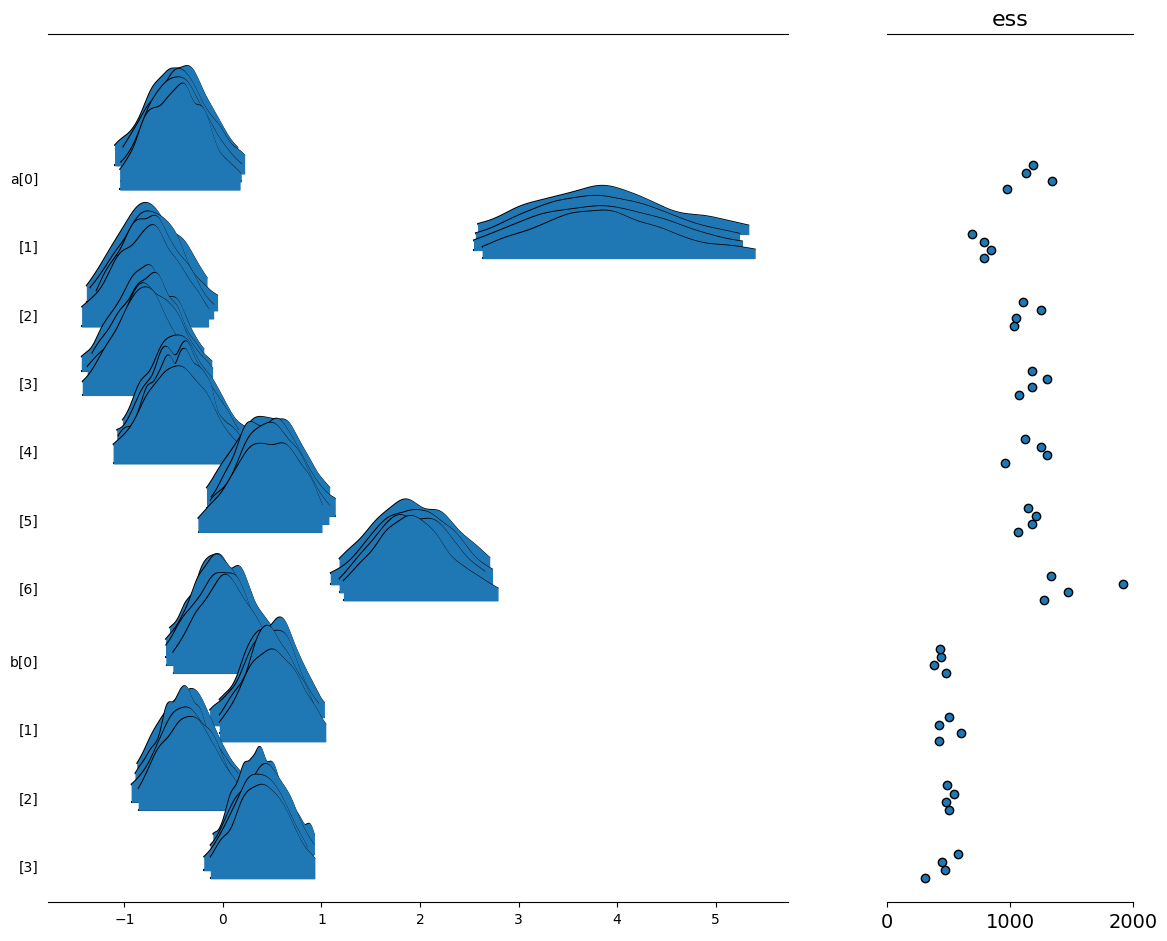

In [2]:
m11_4.diag_forest()

# Poisson

In [22]:
from main import*
d = pd.read_csv('./data/Kline.csv', sep = ';')
d["P"] = d.population.pipe(np.log).pipe(lambda x: (x - x.mean()) / x.std())
d["cid"] = (d.contact == "high").astype(int)
d['pLog'] = tf.math.log(d.P).numpy()
d

,culture,population,contact,total_tools,mean_TU,P,cid,pLog
0,Malekula,1100,low,13,3.2,-1.291473,0,NaN
1,Tikopia,1500,low,22,4.7,-1.088551,0,NaN
2,Santa Cruz,3600,low,24,4.0,-0.515765,0,NaN
3,Yap,4791,high,43,5.0,-0.328773,1,NaN
4,Lau Fiji,7400,high,33,5.0,-0.044339,1,NaN
5,Trobriand,8000,high,19,4.0,0.006668,1,-5.010392
6,Chuuk,9200,high,40,3.8,0.098109,1,-2.321674
7,Manus,13000,low,28,6.6,0.324318,0,-1.126032
8,Tonga,17500,high,55,5.4,0.518798,1,-0.656241
9,Hawaii,275000,low,71,6.6,2.321008,0,0.842002


In [25]:
formula = dict(main = 'total_tools ~ Poisson(log_rate = lambda)',
               likelihood = 'lambda ~ alpha',
               prior1 = 'alpha ~ Normal(3,0.5)')
m11_9 = model(formula, d)
m11_9.fit(observed_data = dict(total_tools =d.total_tools.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m11_9.summary()
#Expected
#  mean   sd 5.5% 94.5% rhat ess_bulk
#a 3.54 0.05 3.46  3.63 1.01   679.05

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],3.54,0.05,3.46,3.63


In [26]:
formula = dict(main = 'total_tools ~ Poisson(log_rate = lambda)',
               likelihood = 'lambda ~ alpha[cid] + beta[cid]*P',
               prior1 = 'alpha ~ Normal(3,0.5)',
               prior2 = 'beta ~ Normal(0,0.2)')
m11_10 = model(formula, d)
m11_10.fit(observed_data = dict(total_tools =d.total_tools.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m11_10.summary()
# Expected
#     mean   sd     5.5%    94.5% rhat ess_bulk
#a[1] 3.32  0.09     3.19   3.46    1  1553.42
#a[2] 3.61  0.07     3.49   3.73    1  2004.06
#b[1] 0.38  0.05     0.29   0.46    1  1769.96
#b[2] 0.18  0.16    -0.07   0.45    1  1747.86

,mean,sd,hdi_5.5%,hdi_94.5%
beta[0],0.38,0.05,0.30,0.46
beta[1],0.19,0.16,-0.05,0.45
alpha[0],3.32,0.08,3.19,3.45
alpha[1],3.61,0.07,3.50,3.73


In [31]:
m11_9.diag_compare({'m11_9': m11_9.trace, 'm11_10': m11_10.trace})
# Expected
#       PSIS    SE      dPSIS   dSE     pPSIS weight
#m11.10 84.6    13.24   0.0     NA      6.6     1
#m11.9 141.8    33.78   57.2    33.68   8.5     0

/home/sosa/.local/lib/python3.10/site-packages/arviz/stats/stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/sosa/.local/lib/python3.10/site-packages/arviz/stats/stats.py:839: UserWarning: The point-wise LOO is the same with the sum LOO, please double check the Observed RV in your model to make sure it returns element-wise logp.
  warnings.warn(
/home/sosa/.local/lib/python3.10/site-packages/arviz/stats/stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well i

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m11_10,0,-42.375114,2.449944,0.000000,1.0,0.0,0.0,True,log
m11_9,1,-67.918549,1.043472,25.543434,0.0,0.0,0.0,True,log


In [33]:
formula = dict(main = 'total_tools ~ Poisson(log_rate = lambda)',
               likelihood = 'lambda ~ alpha[cid] + P^beta[cid]',
               prior1 = 'alpha ~ Normal(3,0.5)',
               prior2 = 'beta ~ Normal(0,0.2)')
m11_10 = model(formula, d)
m11_10.fit(observed_data = dict(total_tools =d.total_tools.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m11_10.summary()

SyntaxError: invalid syntax (<string>, line 1)